# Model Training: Boosting Models (XGBoost & LightGBM)

Ce notebook charge les données depuis `Data/` et entraîne des modèles de gradient boosting pour prédire `target_7` et `target_30`.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
import matplotlib.pyplot as plt

os.makedirs('trained_models', exist_ok=True)
print("✅ Bibliothèques importées.")

✅ Bibliothèques importées.


/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Chargement des Données

In [2]:
train_path = 'Data/train_boosting.csv'
test_path = 'Data/test_boosting.csv'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Fichiers introuvables dans Data/.")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"📦 Train: {train_df.shape}, Test: {test_df.shape}")

📦 Train: (48600, 71), Test: (18500, 71)


## Fonction d'Entraînement
Nous définissons une fonction pour entraîner et évaluer les modèles pour une cible donnée.

In [3]:
def train_evaluate_save(target_col, suffix):
    print(f"\n🎯 Traitement pour {target_col}...")
    
    # Préparation des données
    # On retire les deux targets des features
    drop_cols = ['target_7', 'target_30']
    
    X_train = train_df.drop(columns=drop_cols, errors='ignore')
    y_train = train_df[target_col]
    
    X_test = test_df.drop(columns=drop_cols, errors='ignore')
    y_test = test_df[target_col]
    
    # Filtrage numérique uniquement
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])
    
    # Alignement
    X_train = X_train[X_test.columns]
    
    # --- XGBoost ---
    print("  ⏳ XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Évaluation XGB
    xgb_pred = xgb_model.predict(X_test)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print(f"    ✅ XGB RMSE: {xgb_rmse:.4f}")
    
    # Sauvegarde XGB
    joblib.dump(xgb_model, f'trained_models/xgboost_model_{suffix}.pkl')

    # --- LightGBM ---
    print("  ⏳ LightGBM...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
    )
    
    # Évaluation LGBM
    lgb_pred = lgb_model.predict(X_test)
    lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
    print(f"    ✅ LGB RMSE: {lgb_rmse:.4f}")
    
    # Sauvegarde LGBM
    joblib.dump(lgb_model, f'trained_models/lightgbm_model_{suffix}.pkl')
    
    return y_test, xgb_pred, lgb_pred

## Exécution pour target_7 et target_30

In [4]:
# Target 7
y7, xgb7, lgb7 = train_evaluate_save('target_7', '7')

# Target 30
y30, xgb30, lgb30 = train_evaluate_save('target_30', '30')


🎯 Traitement pour target_7...
  ⏳ XGBoost...
    ✅ XGB RMSE: 109.3214
  ⏳ LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5127
[LightGBM] [Info] Number of data points in the train set: 48600, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 136.362675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 109.335	valid_0's l2: 11954.1
    ✅ LGB RMSE: 109.3348

🎯 Traitement pour target_30...
  ⏳ XGBoost...
    ✅ XGB RMSE: 108.5376
  ⏳ LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

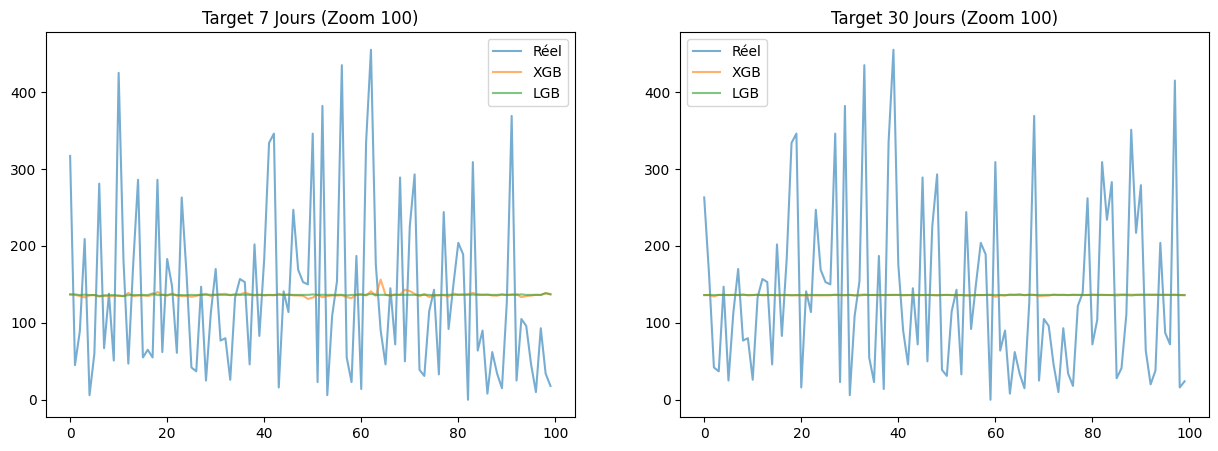

In [5]:
# Visualisation 7 jours
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(y7.values[:100], label='Réel', alpha=0.6)
plt.plot(xgb7[:100], label='XGB', alpha=0.6)
plt.plot(lgb7[:100], label='LGB', alpha=0.6)
plt.title("Target 7 Jours (Zoom 100)")
plt.legend()

# Visualisation 30 jours
plt.subplot(1, 2, 2)
plt.plot(y30.values[:100], label='Réel', alpha=0.6)
plt.plot(xgb30[:100], label='XGB', alpha=0.6)
plt.plot(lgb30[:100], label='LGB', alpha=0.6)
plt.title("Target 30 Jours (Zoom 100)")
plt.legend()

plt.show()